Import dataset menggunakan Kaggle API

In [79]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d arashnic/book-recommendation-dataset

mkdir: cannot create directory ‘/root/.kaggle’: File exists
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset
License(s): CC0-1.0
book-recommendation-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [80]:
!unzip /content/book-recommendation-dataset.zip

Archive:  /content/book-recommendation-dataset.zip
replace Books.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Books.csv               
replace DeepRec.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace DeepRec.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: DeepRec.png             
  inflating: Ratings.csv             
  inflating: Users.csv               
  inflating: classicRec.png          
  inflating: recsys_taxonomy2.png    


In [81]:
# Import library
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

Setiap file .csv dibaca dan dimasukkan ke dataframe masing-masing

In [82]:
books = pd.read_csv('/content/Books.csv')
ratings = pd.read_csv('/content/Ratings.csv')
users = pd.read_csv('/content/Users.csv')

print('Jumlah buku: ', len(books['ISBN'].unique()))
print('Jumlah rating: ', ratings.groupby(['ISBN', 'User-ID']).ngroups)
print('Jumlah user: ', len(users['User-ID'].unique()))

<ipython-input-82-1daac3b93adc>:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv('/content/Books.csv')


Jumlah buku:  271360
Jumlah rating:  1149780
Jumlah user:  278858


# EDA

Dilihat fitur yang dimiliki Books

In [83]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271358 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


Dilihat statistik data yang dimiliki Books

In [84]:
books.describe()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
count,271360,271360,271358,271360,271358,271360,271360,271357
unique,271360,242135,102022,202,16807,271044,271044,271041
top,3462017942,Selected Poems,Agatha Christie,2002,Harlequin,http://images.amazon.com/images/P/042509474X.0...,http://images.amazon.com/images/P/042509474X.0...,http://images.amazon.com/images/P/006091985X.0...
freq,1,27,632,13903,7535,2,2,2


Dilihat fitur yang dimiliki Ratings

In [85]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


Dilihat statistik data yang dimiliki Ratings

In [86]:
ratings.describe()

,User-ID,Book-Rating
count,1.149780e+06,1.149780e+06
mean,1.403864e+05,2.866950e+00
std,8.056228e+04,3.854184e+00
min,2.000000e+00,0.000000e+00
25%,7.034500e+04,0.000000e+00
50%,1.410100e+05,0.000000e+00
75%,2.110280e+05,7.000000e+00
max,2.788540e+05,1.000000e+01


Dapat dilihat bahwa rating berada antara 0 sampai 10

Dilihat fitur yang dimiliki Users

In [87]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


Dilihat statistik data yang dimiliki Users

In [88]:
users.describe()

,User-ID,Age
count,278858.00000,168096.000000
mean,139429.50000,34.751434
std,80499.51502,14.428097
min,1.00000,0.000000
25%,69715.25000,24.000000
50%,139429.50000,32.000000
75%,209143.75000,44.000000
max,278858.00000,244.000000


Dapat dilihat bahwa max Age adalah 244, sehingga perlu ditangani, juga ada perbedaan count antara User-ID dan Age, ini menandakan bahwa ada missing values

# Data Preperation

Dilakukan merge antara ratings dan books pada kolom ISBN

In [89]:
# Menggabungkan all resto_rate dengan dataframe geo berdasarkan placeID
books_rate = pd.merge(ratings, books[['ISBN','Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher']], on='ISBN', how='right')

# Print dataframe all_resto_name
books_rate

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,2.0,0195153448,0.0,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,8.0,0002005018,5.0,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,11400.0,0002005018,0.0,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
3,11676.0,0002005018,8.0,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
4,41385.0,0002005018,0.0,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
...,...,...,...,...,...,...,...
1032340,276463.0,0440400988,7.0,There's a Bat in Bunk Five,Paula Danziger,1988,Random House Childrens Pub (Mm)
1032341,276579.0,0525447644,4.0,From One to One Hundred,Teri Sloat,1991,Dutton Books
1032342,276680.0,006008667X,0.0,Lily Dale : The True Story of the Town that Ta...,Christine Wicker,2004,HarperSanFrancisco
1032343,276680.0,0192126040,0.0,Republic (World's Classics),Plato,1996,Oxford University Press


Kemudian dilakukan juga merge dengan Users pada User-ID

In [14]:
# Menggabungkan all resto_rate dengan dataframe geo berdasarkan placeID
all_books = pd.merge(books_rate, users[['User-ID', 'Age']], on='User-ID', how='left')

# Print dataframe all_resto_name
all_books

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Age
0,2.0,0195153448,0.0,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,18.0
1,8.0,0002005018,5.0,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,NaN
2,11400.0,0002005018,0.0,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,49.0
3,11676.0,0002005018,8.0,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,NaN
4,41385.0,0002005018,0.0,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,NaN
...,...,...,...,...,...,...,...,...
1032340,276463.0,0440400988,7.0,There's a Bat in Bunk Five,Paula Danziger,1988,Random House Childrens Pub (Mm),26.0
1032341,276579.0,0525447644,4.0,From One to One Hundred,Teri Sloat,1991,Dutton Books,12.0
1032342,276680.0,006008667X,0.0,Lily Dale : The True Story of the Town that Ta...,Christine Wicker,2004,HarperSanFrancisco,55.0
1032343,276680.0,0192126040,0.0,Republic (World's Classics),Plato,1996,Oxford University Press,55.0


## Outliers dan Missing Values

Dilakukan penanganan outliers pada fitur numerik. Pertama dilakukan visualisasi boxplot terlebih dahulu terhadap data

<Axes: xlabel='Age'>

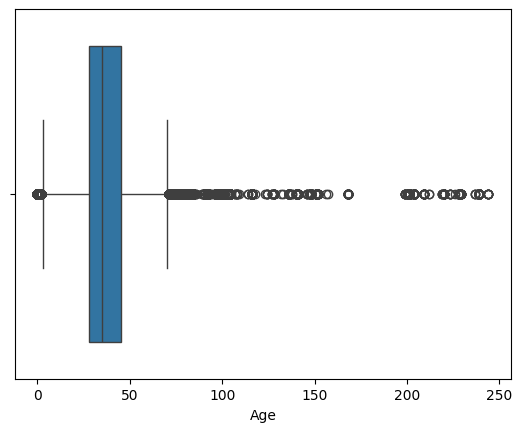

In [15]:
import seaborn as sns

sns.boxplot(x=all_books['Age'])

Terlihat Age memiliki beberapa outliers

<Axes: xlabel='Book-Rating'>

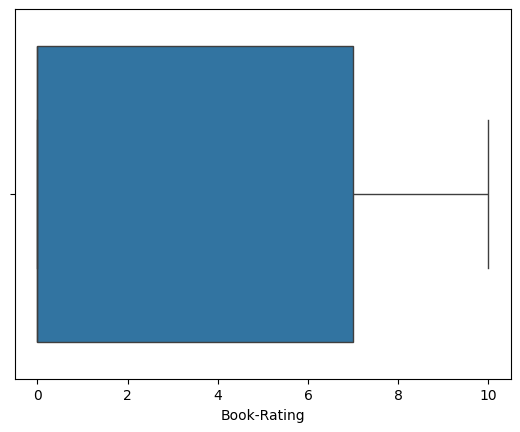

In [16]:
sns.boxplot(x=all_books['Book-Rating'])

Terlihat Book-Rating tidak memiliki outliers

In [17]:
print(len(all_books['Year-Of-Publication'].str.contains('')==True))

1032345


Jika dicek kolom Year-Od-Publication, terlihat bahwa ada beberapa data yang memiliki String sementara Year sendiri seharusnya hanya angka atau int sehingga perlu diperbaiki

In [18]:
filter = all_books['Year-Of-Publication'].str.contains('')==True
all_books_filtered = all_books[~filter]
all_books_filtered.shape

(951527, 8)

Setelah di filter terlihat bahwa hanya tersisa 951527 baris data, kemudian kolom ini dijadikan tipe int agar sesuai

In [19]:
all_books_filtered['Year-Of-Publication'].astype(int)

0          2002
1          2001
2          2001
3          2001
4          2001
           ... 
1032340    1988
1032341    1991
1032342    2004
1032343    1996
1032344    2000
Name: Year-Of-Publication, Length: 951527, dtype: int64

Dilakukan visualisasi boxplot Year-Of-Publication untuk melihat outliers

<Axes: xlabel='Year-Of-Publication'>

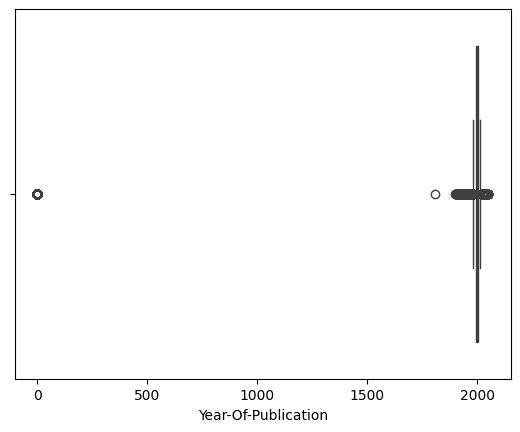

In [20]:
sns.boxplot(x=all_books_filtered['Year-Of-Publication'])

Dapat dilihat bahwa beberapa data merupakan outliers, bahkan ada yang tahun 0

Dilakukan penanganan outliers terhadap Age dan Year-Of-Publication menggunakan IQR seperti berikut

In [21]:
columns = ['Age','Year-Of-Publication']

df = all_books_filtered
for column in columns:
  Q1 = df[column].quantile(0.25)
  Q3 = df[column].quantile(0.75)
  IQR=Q3-Q1
  df=df[~((df[column]<(Q1-1.5*IQR))|(df[column]>(Q3+1.5*IQR)))]

Kemudian dicek bahwa outliers sudah terhapus

<Axes: xlabel='Age'>

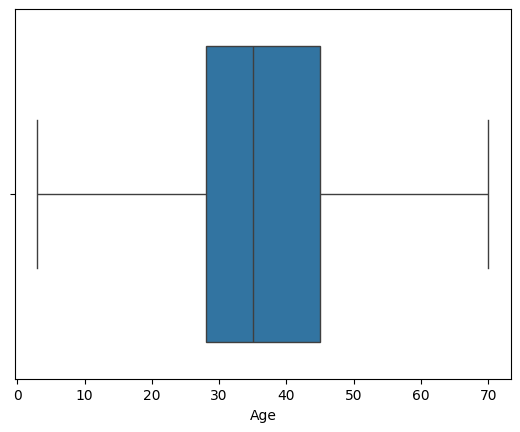

In [22]:
sns.boxplot(x=df['Age'])

<Axes: xlabel='Year-Of-Publication'>

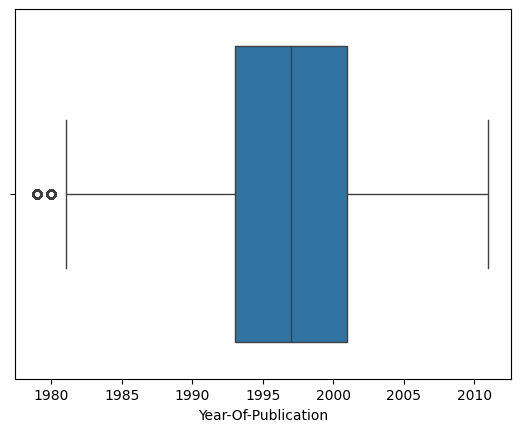

In [23]:
sns.boxplot(x=df['Year-Of-Publication'])

Dilakukan pengecekan missing values

In [24]:
# Mengecek missing value pada dataframe all_resto
df.isnull().sum()

User-ID                   235
ISBN                        0
Book-Rating               235
Book-Title                  0
Book-Author                 2
Year-Of-Publication         0
Publisher                   2
Age                    245913
dtype: int64

Terlihat bahwa ada missing values dengan jumlah terbanyak di Age. Missing values tersebut kemudian di drop

In [25]:
df_clean = all_books_filtered.dropna()
df_clean.isnull().sum()

User-ID                0
ISBN                   0
Book-Rating            0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Publisher              0
Age                    0
dtype: int64

In [26]:
df_clean.shape

(905998, 8)

Terlihat bahwa data yang tersisa adalah 905998 baris

## Collaborative Filtering

In [28]:
df = df_clean

Dilakukan encoding pada User-ID dan ISBN ke dalam indeks integer

In [29]:
user_ids = df['User-ID'].unique().tolist()
print('list userID: ', user_ids)

user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
print('encoded userID : ', user_to_user_encoded)

user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}
print('encoded angka ke userID: ', user_encoded_to_user)

list userID:  [2.0, 11400.0, 67544.0, 85526.0, 96054.0, 177458.0, 219008.0, 263325.0, 2954.0, 152827.0, 35704.0, 83160.0, 110912.0, 137688.0, 157969.0, 192665.0, 197659.0, 29526.0, 36836.0, 46398.0, 67958.0, 113270.0, 115097.0, 136509.0, 180297.0, 188589.0, 200674.0, 207148.0, 211919.0, 230522.0, 238557.0, 242247.0, 252282.0, 252921.0, 255661.0, 52614.0, 56193.0, 225910.0, 274634.0, 166596.0, 223066.0, 3363.0, 174304.0, 177090.0, 176875.0, 213915.0, 226745.0, 277478.0, 278144.0, 388.0, 2977.0, 5760.0, 6795.0, 7346.0, 7352.0, 9856.0, 11224.0, 12923.0, 13552.0, 13582.0, 16795.0, 20435.0, 20801.0, 21264.0, 23511.0, 23768.0, 26544.0, 29654.0, 30487.0, 31299.0, 31315.0, 31556.0, 32516.0, 35857.0, 36606.0, 37874.0, 38991.0, 39345.0, 39646.0, 40889.0, 41781.0, 46389.0, 46767.0, 47971.0, 48268.0, 48911.0, 49168.0, 49994.0, 52584.0, 54005.0, 54884.0, 55027.0, 55492.0, 57108.0, 59038.0, 60130.0, 60569.0, 60683.0, 62667.0, 62881.0, 63470.0, 64535.0, 66387.0, 67487.0, 68256.0, 68537.0, 69232.0, 70

In [30]:
book_ids = df['ISBN'].unique().tolist()

book_to_book_encoded = {x: i for i, x in enumerate(book_ids)}

book_encoded_to_book = {i: x for i, x in enumerate(book_ids)}

In [46]:
df.loc[:,'User-ID'] = df['User-ID'].map(user_to_user_encoded)

df.loc[:,'ISBN'] = df['ISBN'].map(book_to_book_encoded)

Dilakukan pengecekan jumlah user dan books, juga dilakukan pengbuhan tipe rating menjadi float

In [47]:
# Mendapatkan jumlah user
num_users = len(user_to_user_encoded)
print(num_users)

# Mendapatkan jumlah resto
num_book = len(book_encoded_to_book)
print(num_book)

# Mengubah rating menjadi nilai float
df['Book-Rating'] = df['Book-Rating'].values.astype(np.float32)

# Nilai minimum rating
min_rating = min(df['Book-Rating'])

# Nilai maksimal rating
max_rating = max(df['Book-Rating'])

print('Number of User: {}, Number of Books: {}, Min Rating: {}, Max Rating: {}'.format(
    num_users, num_book, min_rating, max_rating
))

52015
179721
Number of User: 52015, Number of Resto: 179721, Min Rating: 0.0, Max Rating: 10.0


## Train Test Split

Dilakukan pengacakan dataset untuk menghindari suatu urutan atau bias dari dataset

In [34]:
# Mengacak dataset
df = df.sample(frac=1, random_state=42)
df

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Age
53674,6238,995,0.0,While I Was Gone,Sue Miller,1999,Ballantine Books,26.0
590440,3282,49021,0.0,The China Garden,Liz Berry,1999,HarperTempest,33.0
387241,3679,19073,0.0,Just Ella,Margaret Peterson Haddix,2001,Aladdin,37.0
475160,1993,29147,0.0,Don't Close Your Eyes,Carlene Thompson,2000,St. Martin's Press,37.0
757292,3554,90358,10.0,Make Room For Mommy (Debut Author) (Silhouett...,Suzanne McMinn,1996,Silhouette,31.0
...,...,...,...,...,...,...,...,...
361624,6751,16769,0.0,Carry on Jeeves,P. G. Wodehouse,1975,Penguin Books,50.0
507451,7152,34018,0.0,Hiss and Tell: True Stories from the Files of ...,Pam Johnson-Bennett,2001,Penguin Books,57.0
185064,21838,5312,0.0,"Good-Bye Stacey, Good-Bye (Baby-Sitters Club (...",Ann M. Martin,1993,Scholastic Paperbacks,9.0
919225,257,159674,0.0,Murder On Peachtree Street,Patricia Houck Sprinkle,1993,Worldwide Library,116.0


Dilakukan train test split dengan rasio 80:20

In [35]:
# Membuat variabel x untuk mencocokkan data user dan resto menjadi satu value
x = df[['User-ID', 'ISBN']].values

# Membuat variabel y untuk membuat rating dari hasil
y = df['Book-Rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Membagi menjadi 80% data train dan 20% data validasi
train_indices = int(0.8 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

print(x, y)

[[  6238    995]
 [  3282  49021]
 [  3679  19073]
 ...
 [ 21838   5312]
 [   257 159674]
 [  1540   4716]] [0. 0. 0. ... 0. 0. 0.]


# Training

Dibuat class RecommenderNet yang berisi arsitektur model yang akan digunakan, model akan menghitung skor kecocokan antara pengguna dan resto dengan dot product dan teknik embedding

In [36]:
class RecommenderNet(tf.keras.Model):

  # Insialisasi fungsi
  def __init__(self, num_users, num_resto, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_resto = num_resto
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding( # layer embedding user
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1) # layer embedding user bias
    self.resto_embedding = layers.Embedding( # layer embeddings resto
        num_resto,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.resto_bias = layers.Embedding(num_resto, 1) # layer embedding resto bias

  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0]) # memanggil layer embedding 1
    user_bias = self.user_bias(inputs[:, 0]) # memanggil layer embedding 2
    resto_vector = self.resto_embedding(inputs[:, 1]) # memanggil layer embedding 3
    resto_bias = self.resto_bias(inputs[:, 1]) # memanggil layer embedding 4

    dot_user_resto = tf.tensordot(user_vector, resto_vector, 2)

    x = dot_user_resto + user_bias + resto_bias

    return tf.nn.sigmoid(x) # activation sigmoid

Dilakukan compile terhadap model dengan loss BinaryCrossentropy, optimizer Adam, dan metrik RMSE. Digunakan metrik RMSE untuk mengukur akurasi prediksi rating model

In [39]:
model = RecommenderNet(num_users, num_book, 50) # inisialisasi model

# model compile
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

Dilakukan training menggunakan batch_size=32 dan epoch=10

In [44]:
# Memulai training

history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 32,
    epochs = 10,
    validation_data = (x_val, y_val)
)

Epoch 1/10
17394/17394 [==============================] - 171s 10ms/step - loss: 0.4633 - root_mean_squared_error: 0.3050 - val_loss: 0.5404 - val_root_mean_squared_error: 0.3508
Epoch 2/10
17394/17394 [==============================] - 160s 9ms/step - loss: 0.4412 - root_mean_squared_error: 0.2971 - val_loss: 0.5417 - val_root_mean_squared_error: 0.3508
Epoch 3/10
17394/17394 [==============================] - 156s 9ms/step - loss: 0.4361 - root_mean_squared_error: 0.2948 - val_loss: 0.5428 - val_root_mean_squared_error: 0.3519
Epoch 4/10
17394/17394 [==============================] - 168s 10ms/step - loss: 0.4334 - root_mean_squared_error: 0.2934 - val_loss: 0.5461 - val_root_mean_squared_error: 0.3527
Epoch 5/10
17394/17394 [==============================] - 158s 9ms/step - loss: 0.4321 - root_mean_squared_error: 0.2926 - val_loss: 0.5489 - val_root_mean_squared_error: 0.3536
Epoch 6/10
17394/17394 [==============================] - 142s 8ms/step - loss: 0.4307 - root_mean_squared_e

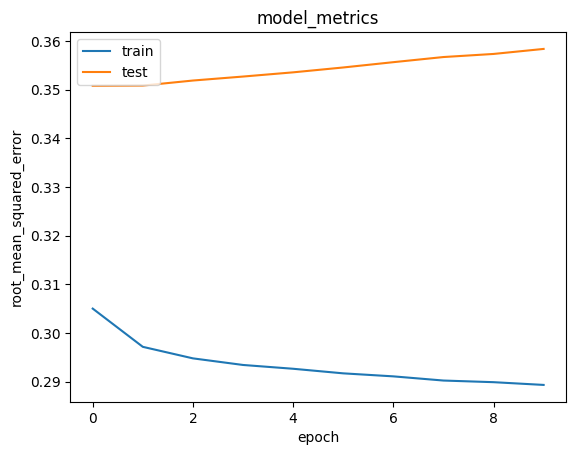

In [48]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Dapat dilihat bahwa error untuk train data semakin menurun sementara error dari data uji meningkat. Hal ini dapat menandakan bahwa model mengalami overfitting

# Prediction

Dibuat dictionary yang berisi seluruh buku dengan isbn, book_name, dan author

In [91]:
isbn = books['ISBN'].tolist()
author = books['Book-Author'].tolist()
title = books['Book-Title'].tolist()

books_new = pd.DataFrame({
    'isbn': isbn,
    'book_name': title,
    'author': author
})
books_new

,isbn,book_name,author
0,0195153448,Classical Mythology,Mark P. O. Morford
1,0002005018,Clara Callan,Richard Bruce Wright
2,0060973129,Decision in Normandy,Carlo D'Este
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata
4,0393045218,The Mummies of Urumchi,E. J. W. Barber
...,...,...,...
271355,0440400988,There's a Bat in Bunk Five,Paula Danziger
271356,0525447644,From One to One Hundred,Teri Sloat
271357,006008667X,Lily Dale : The True Story of the Town that Ta...,Christine Wicker
271358,0192126040,Republic (World's Classics),Plato


Kemudian dilakukan prediksi untuk mendapat rekomendasi buku sesuai user

In [92]:
books_df = books_new
df = pd.read_csv('/content/Ratings.csv')

# Mengambil sample user
user_id = df['User-ID'].sample(1).iloc[0]
books_read = df[df['User-ID'] == user_id]

books_not_read = books_df[~books_df['isbn'].isin(books_read['ISBN'].values)]['isbn']
books_not_read = list(
    set(books_not_read)
    .intersection(set(book_to_book_encoded.keys()))
)

books_not_read = [[book_to_book_encoded.get(x)] for x in books_not_read]
user_encoder = user_to_user_encoded.get(user_id)
user_resto_array = np.hstack(
    ([[user_encoder]] * len(books_not_read), books_not_read)
)

In [96]:
ratings = model.predict(user_resto_array).flatten()

top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_books_ids = [
    book_encoded_to_book.get(books_not_read[x][0]) for x in top_ratings_indices
]

5599/5599 [==============================] - 11s 2ms/step


In [98]:
print('Showing recommendations for users: {}'.format(user_id))
print('===' * 9)
print('Books with high ratings from user')
print('----' * 8)

top_books_user = (
    books_read.sort_values(
        by = 'Book-Rating',
        ascending=False
    )
    .head(5)
    .ISBN.values
)

books_df_rows = books_df[books_df['isbn'].isin(top_books_user)]
books_df_rows

for row in books_df_rows.itertuples():
    print(row[2],'by', row[3])

print('----' * 8)
print('Top 10 Book recommendation')
print('----' * 8)

recommended_books = books_df[books_df['isbn'].isin(recommended_books_ids)]
for row in recommended_books.itertuples():
    print(row[2],'by', row[3])

Showing recommendations for users: 63714
Books with high ratings from user
--------------------------------
Collins Gem Fossils (Collins Gems) by David Martill
Arthur Conan Doyle: A Life by Hesketh Pearson
--------------------------------
Top 10 Book recommendation
--------------------------------
The Outlandish Companion by DIANA GABALDON
The Lord of the Rings (Leatherette Collector's Edition) by J. R. R. Tolkien
The Last Battle (The Chronicles of Narnia, Book 7) by C. S. Lewis
Death: The High Cost of Living by Neil Gaiman
The Lorax by Dr. Seuss
The Hobbit by J. R. R. Tolkien
The Selected Poetry of Rainer Maria Rilke by RAINER MARIA RILKE
Love You Forever by Robert Munsch
Le Combat ordinaire, tome 1 by Larcenet
Die unendliche Geschichte: Von A bis Z by Michael Ende


Dapat dilihat bahwa berhasil diberikan 10 buku rekomendasi bagi user beradasarkan Rating yang telah diberikan User pada buku lain